# Importing Necessary Libraries 

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Basics").getOrCreate()

In [3]:
spark

In [4]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.ml.feature import Bucketizer
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import for typecasting columns
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType,StringType
from pyspark.sql.types import ArrayType

# Reading The Data

### First Reading Raw Recipe Data

In [5]:
Raw_recipes_df = (spark.read.csv("RAW_recipes_cleaned.csv", inferSchema = True, header = True))

In [6]:
Raw_recipes_df.show(5)

+--------------------+------+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+
|                name|    id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|         description|         ingredients|n_ingredients|
+--------------------+------+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+
|arriba   baked wi...|137739|     55|         47892|2005-09-16|['60-minutes-or-l...|[51.5, 0.0, 13.0,...|     11|['make a choice a...|autumn is my favo...|['winter squash',...|            7|
|a bit different  ...| 31490|     30|         26278|2002-06-17|['30-minutes-or-l...|[173.4, 18.0, 0.0...|      9|['preheat oven to...|this recipe calls...|['prepared pizza ...|            6|
|all in the kitche...|112140|    130|        

In [7]:
Raw_recipes_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- contributor_id: integer (nullable = true)
 |-- submitted: date (nullable = true)
 |-- tags: string (nullable = true)
 |-- nutrition: string (nullable = true)
 |-- n_steps: integer (nullable = true)
 |-- steps: string (nullable = true)
 |-- description: string (nullable = true)
 |-- ingredients: string (nullable = true)
 |-- n_ingredients: integer (nullable = true)



In [8]:
# Using asset command for checking cells
assert Raw_recipes_df.count() == 231637, "Mistake, check again"
assert len(Raw_recipes_df.columns) == 12, "Mistake, check again"
assert Raw_recipes_df.schema["minutes"].dataType == IntegerType(), "Mistake reading data type, check again"
assert Raw_recipes_df.schema["tags"].dataType == StringType(), "Mistake reading data type, check again"
assert Raw_recipes_df.schema["n_ingredients"].dataType == IntegerType(), "Mistake reading data type, check again"

In [9]:
Raw_recipes_df.count() == 231637

True

In [10]:
len(Raw_recipes_df.columns) == 12

True

In [11]:
Raw_recipes_df.schema["minutes"].dataType == IntegerType()

True

In [12]:
Raw_recipes_df.schema["tags"].dataType == StringType()

True

In [13]:
Raw_recipes_df.schema["n_ingredients"].dataType == IntegerType()

True

#### Extracting Nutrition Values

In [14]:
# List of Nutrition
nutrition_col_names = ['calories','total_fat_PDV','sugar_PDV','sodium_PDV','protein_PDV','saturated_fat_PDV','carbohydrates_PDV']

In [15]:
Raw_recipes_df.select('nutrition').show(5)

+--------------------+
|           nutrition|
+--------------------+
|[51.5, 0.0, 13.0,...|
|[173.4, 18.0, 0.0...|
|[269.8, 22.0, 32....|
|[368.1, 17.0, 10....|
|[352.9, 1.0, 337....|
+--------------------+
only showing top 5 rows



In [16]:
# Operation to remove square brackets in the column
Raw_recipes_df = (Raw_recipes_df.withColumn('nutrition',(F.regexp_replace('nutrition','[\[\]]',''))))

In [17]:
import pyspark
nutrition_col_split = pyspark.sql.functions.split(Raw_recipes_df['nutrition'],',')

for col_index, col_name in enumerate(nutrition_col_names):
    Raw_recipes_df = (Raw_recipes_df.withColumn(col_name, nutrition_col_split.getItem(col_index).cast('float')))

In [18]:
# Using asset command for checking cells
assert Raw_recipes_df.schema["carbohydrates_PDV"].dataType == FloatType(), "Recheck your typecasting"
assert Raw_recipes_df.collect()[123432][14] == 62.0, "The columns not been split correctly, check again"
assert Raw_recipes_df.collect()[10000][12] == 60.400001525878906, "The columns not been split correctly, check again"

In [19]:
Raw_recipes_df.schema["carbohydrates_PDV"].dataType == FloatType()

True

In [20]:
Raw_recipes_df.collect()[123432][14] == 62.0

True

In [21]:
Raw_recipes_df.collect()[10000][12] == 60.400001525878906

True

### Make Nutrition Per 100 calorie Columns

### Task 03: Standardize the nutrition values 

In [23]:
for nutrition_col in nutrition_col_names:# loop over each of the newly created nutrition columns 
    if nutrition_col != "calories":

        nutrition_per_100_cal_col = (nutrition_col.replace('_PDV','')
                                     +'_per_100_cal')
        Raw_recipes_df = Raw_recipes_df.withColumn(nutrition_per_100_cal_col,
                                               Raw_recipes_df[nutrition_col]*100/Raw_recipes_df["calories"])
         
        
        Raw_Recipes_Df = Raw_recipes_df.fillna(value=0,subset=[nutrition_per_100_cal_col]) 

#### Test cases for Task 03

In [24]:
# total fat check for id 28881
assert Raw_recipes_df.filter("id == 28881").select('total_fat_per_100_cal').first()[0] == 0, "total_fat_per_100_cal for recipe 28881 should be 0"

# total fat check for id 112140
assert round(Raw_recipes_df.filter("id == 112140").select('total_fat_per_100_cal').first()[0]) == 8, "total_fat_per_100_cal for recipe 112140 should be 8"

# checking for nulls
for c in ['total_fat_per_100_cal','sugar_per_100_cal','sodium_per_100_cal','protein_per_100_cal',
                          'saturated_fat_per_100_cal','carbohydrates_per_100_cal']:
    assert Raw_recipes_df.select(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)).collect()[0][0] == 0, "There are Nulls in the data"

AssertionError: total_fat_per_100_cal for recipe 28881 should be 0

#### Sir/Ma'am no matter what I do I can't clear this error, according to the template for id 28881 total_fat_per_100_cal should be 0 but for some reason there's an error. I even re-download the data again but the error is still present. Please advice me on how it can be cleared.

In [25]:
Raw_recipes_df.filter("id == 28881").select('total_fat_per_100_cal').first()[0] == 0

False

In [26]:
round(Raw_recipes_df.filter("id == 112140").select('total_fat_per_100_cal').first()[0]) == 8

True

In [27]:
for c in ['total_fat_per_100_cal','sugar_per_100_cal','sodium_per_100_cal','protein_per_100_cal',
                          'saturated_fat_per_100_cal','carbohydrates_per_100_cal']:
    assert Raw_recipes_df.select(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)).collect()[0][0] == 0

AssertionError: 

#### Similarly what I do I can't clear this error

In [28]:
Raw_recipes_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- contributor_id: integer (nullable = true)
 |-- submitted: date (nullable = true)
 |-- tags: string (nullable = true)
 |-- nutrition: string (nullable = true)
 |-- n_steps: integer (nullable = true)
 |-- steps: string (nullable = true)
 |-- description: string (nullable = true)
 |-- ingredients: string (nullable = true)
 |-- n_ingredients: integer (nullable = true)
 |-- calories: float (nullable = true)
 |-- total_fat_PDV: float (nullable = true)
 |-- sugar_PDV: float (nullable = true)
 |-- sodium_PDV: float (nullable = true)
 |-- protein_PDV: float (nullable = true)
 |-- saturated_fat_PDV: float (nullable = true)
 |-- carbohydrates_PDV: float (nullable = true)
 |-- total_fat_per_100_cal: double (nullable = true)
 |-- sugar_per_100_cal: double (nullable = true)
 |-- sodium_per_100_cal: double (nullable = true)
 |-- protein_per_100_cal: double (nullable = true)
 |-- sa

### Task 04: Convert the tags column from a string to an array of strings 

In [29]:
Raw_recipes_df = (Raw_recipes_df.withColumn('tags', F.regexp_replace("tags","[\\[\\]\\']","")).withColumn('tags', F.split("tags",", ")))

In [30]:
Raw_Recipes_Df = (Raw_Recipes_Df.withColumn('tags',F.split('tags',',').cast(ArrayType(StringType(),True))))

In [31]:
Raw_recipes_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- contributor_id: integer (nullable = true)
 |-- submitted: date (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- nutrition: string (nullable = true)
 |-- n_steps: integer (nullable = true)
 |-- steps: string (nullable = true)
 |-- description: string (nullable = true)
 |-- ingredients: string (nullable = true)
 |-- n_ingredients: integer (nullable = true)
 |-- calories: float (nullable = true)
 |-- total_fat_PDV: float (nullable = true)
 |-- sugar_PDV: float (nullable = true)
 |-- sodium_PDV: float (nullable = true)
 |-- protein_PDV: float (nullable = true)
 |-- saturated_fat_PDV: float (nullable = true)
 |-- carbohydrates_PDV: float (nullable = true)
 |-- total_fat_per_100_cal: double (nullable = true)
 |-- sugar_per_100_cal: double (nullable = true)
 |-- sodium_per_100_cal: double (nullable = true)
 |-- prote

In [36]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

assert Raw_recipes_df.schema["tags"].dataType == ArrayType(StringType(), True), "You have not split the string into an array."
assert Raw_recipes_df.collect()[2][5] == ['time-to-make','course', 'preparation', 'main-dish', 'chili', 'crock-pot-slow-cooker', 'dietary', 'equipment', '4-hours-or-less'], "Recheck your string cleaning and splitting operations."

AssertionError: You have not split the string into an array.

#### This task 4 assertion error no matter what I do I can't clear it. During the pre assignment class expert Amit Ranjan also tries and after the class gave a solution but still it doesn't work.

In [37]:
Raw_recipes_df.schema["tags"].dataType == ArrayType(StringType(), True)


False

In [38]:
Raw_recipes_df.collect()[2][5] == ['time-to-make','course', 'preparation', 'main-dish', 'chili', 'crock-pot-slow-cooker', 'dietary', 'equipment', '4-hours-or-less']

True

# Join Recipe Data to Review Data

In [40]:
# Reading the second data set. 
# keep this cell unedited

Raw_ratings_df = (spark.read.csv("RAW_interactions_cleaned.csv", 
                                 header=True, 
                                 inferSchema= True)
                  .withColumn("review_date",  F.col("date"))
                  .drop(F.col("date"))
                  )

In [41]:
Raw_ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- recipe_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- review_date: date (nullable = true)



In [42]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

assert Raw_ratings_df.count() == 1132367, "Mistake, check again"
assert len(Raw_ratings_df.columns) == 5, "Mistake, check again"

In [43]:
Raw_ratings_df.show(5)

+-------+---------+------+--------------------+-----------+
|user_id|recipe_id|rating|              review|review_date|
+-------+---------+------+--------------------+-----------+
|  38094|    40893|     4|Great with a sala...| 2003-02-17|
|1293707|    40893|     5|So simple  so del...| 2011-12-21|
|   8937|    44394|     4|This worked very ...| 2002-12-01|
| 126440|    85009|     5|I made the Mexica...| 2010-02-27|
|  57222|    85009|     5|Made the cheddar ...| 2011-10-01|
+-------+---------+------+--------------------+-----------+
only showing top 5 rows



### Task 05: Read the second data file 

In [44]:
Interaction_level_df = Raw_ratings_df.join(Raw_recipes_df,Raw_ratings_df.recipe_id == Raw_recipes_df.id,"inner")                                          

#### Test cases for Task 05

In [45]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

assert (Interaction_level_df.count() ,len(Interaction_level_df.columns)) == (1132367, 30), "The type of join is incorrect"

list1 = Raw_ratings_df.select('recipe_id').collect()
list2 = Raw_recipes_df.select('id').collect()
exclusive_set = set(list1)-set(list2)

assert len(exclusive_set) == 0, "There is a mistake in reading one of the two data files."

In [46]:
(Interaction_level_df.count() ,len(Interaction_level_df.columns)) == (1132367, 30)

True

# Task 06: Create time-based features

In [47]:
Interaction_level_df = (Interaction_level_df
                        .withColumn('submitted',F.col("submitted").cast("date"))
                        .withColumn('review_date',F.col("review_date").cast("date")))

In [48]:
Interaction_level_df = (Interaction_level_df
                        .withColumn('days_since_submission_on_review_date',F.datediff("review_date","submitted") # Pyspark function to find the number of days between two dates
                                   )
                        .withColumn('months_since_submission_on_review_date',F.months_between("review_date","submitted") # Pyspark function to find the number of months between two dates
                                   )
                        .withColumn('years_since_submission_on_review_date',F.months_between("review_date","submitted")/12 # Pyspark function to find the number of months between two dates / 12
                                   )
                                   )

### Test cases for Task 06

In [49]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

assert Interaction_level_df.schema["days_since_submission_on_review_date"].dataType == IntegerType()

assert (Interaction_level_df.filter((Interaction_level_df.user_id == 428885) & (Interaction_level_df.recipe_id == 335241))
                            .select('days_since_submission_on_review_date').collect()[0][0]) == 77
assert (Interaction_level_df.filter((Interaction_level_df.user_id == 2025676) & (Interaction_level_df.recipe_id == 94265))
                            .select('months_since_submission_on_review_date').collect()[0][0]) == 153.22580645
assert (Interaction_level_df.filter((Interaction_level_df.user_id == 338588) & (Interaction_level_df.recipe_id == 21859))
                            .select('years_since_submission_on_review_date').collect()[0][0]) == 4.564516129166667

In [50]:
Interaction_level_df.schema["days_since_submission_on_review_date"].dataType == IntegerType()

True

In [51]:
(Interaction_level_df.filter((Interaction_level_df.user_id == 428885) & (Interaction_level_df.recipe_id == 335241))
                            .select('days_since_submission_on_review_date').collect()[0][0]) == 77

True

In [52]:
(Interaction_level_df.filter((Interaction_level_df.user_id == 2025676) & (Interaction_level_df.recipe_id == 94265))
                            .select('months_since_submission_on_review_date').collect()[0][0]) == 153.22580645

True

In [53]:
(Interaction_level_df.filter((Interaction_level_df.user_id == 338588) & (Interaction_level_df.recipe_id == 21859))
                            .select('years_since_submission_on_review_date').collect()[0][0]) == 4.564516129166667

True

# Save the data we have created so far in a parquet file.

In [54]:
Interaction_level_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- recipe_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- contributor_id: integer (nullable = true)
 |-- submitted: date (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- nutrition: string (nullable = true)
 |-- n_steps: integer (nullable = true)
 |-- steps: string (nullable = true)
 |-- description: string (nullable = true)
 |-- ingredients: string (nullable = true)
 |-- n_ingredients: integer (nullable = true)
 |-- calories: float (nullable = true)
 |-- total_fat_PDV: float (nullable = true)
 |-- sugar_PDV: float (nullable = true)
 |-- sodium_PDV: float (nullable = true)
 |-- protein_PDV: float (nullable = true)
 |-- saturated_fat_PDV: float (nullable = true)
 |-- carbo

In [55]:
assert (Interaction_level_df.count() ,len(Interaction_level_df.columns) ) == (1132367, 33)

In [56]:
(Interaction_level_df.count() ,len(Interaction_level_df.columns) ) == (1132367, 33)

True

In [57]:
Interaction_level_df.show(5)

+-------+---------+------+--------------------+-----------+--------------------+---+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+--------+-------------+---------+----------+-----------+-----------------+-----------------+---------------------+-----------------+------------------+-------------------+-------------------------+-------------------------+------------------------------------+--------------------------------------+-------------------------------------+
|user_id|recipe_id|rating|              review|review_date|                name| id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|         description|         ingredients|n_ingredients|calories|total_fat_PDV|sugar_PDV|sodium_PDV|protein_PDV|saturated_fat_PDV|carbohydrates_PDV|total_fat_per_100_cal|sugar_per_100_cal|sodium_per_100_cal|protein_per_100_cal|s

# EDA

## Initial Step

In [57]:
# # Run this everytime you create a new spark instance. 

# spark.sparkContext.install_pypi_package("plotly==5.5.0")
# spark.sparkContext.install_pypi_package("pandas==0.25.1")
# spark.sparkContext.install_pypi_package("numpy==1.14.5")
# spark.sparkContext.install_pypi_package("matplotlib==3.1.1")

## Defining Custom Functions

In [58]:
def get_quantiles(df, col_name, quantiles_list = [0.01, 0.25, 0.5, 0.75, 0.99]):
    """
    Takes a numerical column and returns column values at requested quantiles

    Inputs 
    Argument 1: Dataframe
    Argument 2: Name of the column
    Argument 3: A list of quantiles you want to find. Default value [0.01, 0.25, 0.5, 0.75, 0.99]

    Output 
    Returns a dictionary with quantiles as keys and column quantile values as values 
    """
    # Get min, max and quantile values for given column
    min_val = df.agg(F.min(col_name)).first()[0]
    max_val = df.agg(F.max(col_name)).first()[0]
    quantiles_vals = df.approxQuantile(col_name,
                                       quantiles_list,
                                       0)
  
    # Store min, quantiles and max in output dict, sequentially
    quantiles_dict = {0.0:min_val}
    quantiles_dict.update(dict(zip(quantiles_list, quantiles_vals)))
    quantiles_dict.update({1.0:max_val})
    return(quantiles_dict)

In [59]:

def plot_bucketwise_statistics (summary, bucketizer):
    """
    Takes in a dataframe and a bucketizer object and plots the summary statistics for each bucket in the dataframe. 
  
    Inputs
    Argument 1: Pandas dataframe obtained from bucket_col_print_summary function 
    Argument 2: Bucketizer object obtained from bucket_col_print_summary function
  
    Output
    Displays a plot of bucketwise average ratings nunber of ratings of a parameter.   
    """
    # Creating bucket labels from splits
    classlist = bucketizer.getSplits()
    number_of_classes = len(classlist) - 1

    class_labels = []
    hover_labels = []
    for i in range (number_of_classes):
        hover_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) +" (Bucket name: "+ str(int(i)) +")"  )
        class_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) )
  
    summary["Scaled_number"] = (summary["n_ratings"]-summary["n_ratings"].min())/(summary["n_ratings"].max()-summary["n_ratings"].min()) + 1.5
    summary['Bucket_Names'] = class_labels
  
    # making plot
    x = summary["Bucket_Names"]
    y1 = summary["avg_rating"]
    y2 = summary["n_ratings"]
    err = summary["stddev_rating"]  

    # Plot scatter here
    plt.rcParams["figure.figsize"] = [summary.shape[0]+2, 6.0]
    plt.rcParams["figure.autolayout"] = True
    fig, ax1 = plt.subplots()

    bar = ax1.bar(x, y1, color = "#262261")
    ax1.errorbar(x, y1, yerr=err, fmt="o", color="#EE4036")
    ax1.set(ylim=(0, 7))
  
    #ax1.bar_label(bar , fmt='%.2f', label_type='edge')  
    def barlabel(x_list,y_list):
        for i in range(len(x_list)):
            ax1.text(i,y_list[i] + 0.2,y_list[i], ha = 'center',
  			         fontdict=dict(size=10),
  			         bbox=dict(facecolor='#262261', alpha=0.2)         
  			        )
    barlabel(summary["Bucket_Names"].tolist() ,summary["avg_rating"].round(2).tolist())
  
    ax2 = ax1.twinx()
    ax2.scatter(x, y2, s=summary["Scaled_number"]*500, c = '#FAAF40')  
    ax2.set(ylim=(0, summary["n_ratings"].max()*1.15))
    def scatterlabel(x_list,y_list):
  	    for i in range(len(x_list)):
  		    ax2.text(i,y_list[i] + 15000,y_list[i], ha = 'center',
  					 fontdict=dict(size=10),
                     bbox=dict(facecolor='#FAAF40', alpha=0.5)
  					)
    scatterlabel(summary["Bucket_Names"].tolist() ,summary["n_ratings"].tolist())
  
    # giving labels to the axises
    ax1.set_xlabel(bucketizer.getOutputCol(), fontdict=dict(size=14)) 
    ax1.set_ylabel("Average Ratings",fontdict=dict(size=14))
  
    # secondary y-axis label
    ax2.set_ylabel('Number of Ratings',fontdict=dict(size=14))
  
    #plot Title
    plt.title('Bucketwise average ratings and number of ratings for \n'+bucketizer.getInputCol(), 
              fontdict=dict(size=14))  

In [60]:
def bucket_col_print_summary(df, splits, inputCol, outputCol):
    """
    Given a numerical column in a data frame, adds a bucketized version of the column to the data frame, according to splits provided.
    Also prints a summary of ratings seen in each bucket made.

    Inputs 
    Argument 1: Data Frame 
    Argument 2: Values at which the column will be split
    Argument 3: Name of the input column (numerical column)
    Argument 4: Name of the output column (bucketized numerical column)

    Output: 
    1) New dataframe with the output column added
    2) Bucketizer object trained from the input column 
    3) Pandas dataframe with summary statistics for ratings seen in buckets of the output column
    Also plots summary statistics for ratings seen in buckets of the output column
    """

    # Dropping bucket if it already exists
    if outputCol in df.columns:
        df = df.drop(outputCol)

    # Training bucketizer
    bucketizer = Bucketizer(splits = splits,
                            inputCol  = inputCol,
                            outputCol = outputCol)
    
    df = bucketizer.setHandleInvalid("keep").transform(df)

    # Printing meta information on buckets created
    print("Added bucketized column {}".format(outputCol))
    print("")
    print("Bucketing done for split definition: {}".format(splits))
    print("")  
    print("Printing summary statistics for ratings in buckets below:")

    # Creating a summary statistics dataframe and passing it to the plotting function
    summary =  (df
                .groupBy(outputCol)
                .agg(F.avg('rating').alias('avg_rating'),
                     F.stddev('rating').alias('stddev_rating'),
                     F.count('rating').alias('n_ratings'))
                .sort(outputCol)
                .toPandas())
  
    plot_bucketwise_statistics(summary,bucketizer)
  
    return df, bucketizer, summary

In [61]:
def get_column_distribution_summary(df, col_name):
    """
    Takes a column in a data frame and prints the summary statistics (average, standard deviation, count and distinct count) for all unique values in that column.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Name of the column
  
    Output
    Returns nothing 
    Prints a Dataframe with summary statistics
    """
    print(df
          .groupBy(col_name)
          .agg(F.avg('rating').alias('avg_rating'),
               F.stddev('rating').alias('stddev_rating'),
               F.count('rating').alias('n_ratings'),
               F.countDistinct('id').alias('n_recipes'))
          .sort(F.col(col_name).asc())
          .show(50))

In [62]:
def get_n_items_satisfying_condition (df, condition, aggregation_level = "recipe"):
    """
    Given a condition, find the number of recipes / reviews that match the condition.
    Also calculates the percentage of such recipes / reviews as a percentage of all recipes / reviews.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Logical expression describing a condition, string type. eg: "minutes == 0"
    Argument 3: Aggregation level for determining "items", either  "recipe" or "review". Default value == "recipe"
  
    Output: Returns no object.
    Prints the following:
    1) Number of recipes / reviews that satisfy the condition
    2) Total number of recipes / reviews in the dataframe
    3) Percentage of recipes / reviews that satisfy the condition
    """
    # Find out num rows satisfying the condition
    if aggregation_level == "recipe": 
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id"))).first()[0]
      
        n_rows_total = (df.agg(F.countDistinct("id"))).first()[0]
    if aggregation_level == "review":
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id","user_id"))).first()[0]
        n_rows_total = (df.agg(F.countDistinct("id","user_id"))).first()[0]
  
    # Find out % rows satisfying the conditon and print a properly formatted output
    perc_rows = round(number_of_rows_satisfying_condition * 100/ n_rows_total, 2)
    print('Condition String                   : "{}"'.format(condition))
    print("Num {}s Satisfying Condition   : {} [{}%]".format(aggregation_level.title(), number_of_rows_satisfying_condition, perc_rows))
    print("Total Num {}s                  : {}".format(aggregation_level.title(), n_rows_total))

# Read The Data

In [63]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

assert Interaction_level_df.count() == 1132367, "There is a mistake in reading the data."
assert len(Interaction_level_df.columns) == 33, "There is a mistake in reading the data."

In [61]:
Interaction_level_df.show(5)

+-------+---------+------+--------------------+-----------+--------------------+---+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+--------+-------------+---------+----------+-----------+-----------------+-----------------+---------------------+-----------------+------------------+-------------------+-------------------------+-------------------------+------------------------------------+--------------------------------------+-------------------------------------+
|user_id|recipe_id|rating|              review|review_date|                name| id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|         description|         ingredients|n_ingredients|calories|total_fat_PDV|sugar_PDV|sodium_PDV|protein_PDV|saturated_fat_PDV|carbohydrates_PDV|total_fat_per_100_cal|sugar_per_100_cal|sodium_per_100_cal|protein_per_100_cal|s

# Bucketing and Cleaning Numerical Features

## 1. years_since_submission_on_review_date

In [64]:
get_quantiles(df = Interaction_level_df,
              col_name = "years_since_submission_on_review_date")

{0.0: -4.833333333333333,
 0.01: 0.005376344166666667,
 0.25: 0.8602150541666668,
 0.5: 2.9489247308333333,
 0.75: 5.844086021666667,
 0.99: 14.626344085833333,
 1.0: 19.284946236666666}

In [65]:
get_n_items_satisfying_condition(df = Interaction_level_df,
                                 condition= 'years_since_submission_on_review_date < 0',
                                 aggregation_level= "review")

Condition String                   : "years_since_submission_on_review_date < 0"
Num Reviews Satisfying Condition   : 1246 [0.11%]
Total Num Reviews                  : 1132367


In [66]:
# Only keep interactions with review dates >= recipe submission date

interaction_level_df = (Interaction_level_df
                        .filter('years_since_submission_on_review_date >= 0'))

In [69]:
splits = [ 0, 1, 3, 6, float('Inf')]
inputCol  = "years_since_submission_on_review_date"
outputCol = "years_since_submission_on_review_date_bucket"

(Interaction_level_df, submission_time_bucketizer, submission_time_pandas_df) = bucket_col_print_summary(df = Interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

### 2. minutes
[prep time]

Somewhat relevant
Low prep time is preferred

In [70]:
get_quantiles(df = Interaction_level_df,
              col_name = "minutes",
              quantiles_list=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

{0.0: 0,
 0.01: 2.0,
 0.05: 5.0,
 0.25: 20.0,
 0.5: 40.0,
 0.75: 70.0,
 0.95: 310.0,
 0.99: 930.0,
 1.0: 2147483647}

In [71]:
# Capping prep time at 930 minutes

interaction_level_df = (Interaction_level_df
                        .withColumn("minutes",
                                    F.when(Interaction_level_df["minutes"] > 930, 930)
                                     .otherwise(Interaction_level_df["minutes"])))

In [72]:
# investigating recipes with minutes = 0 -> Look at n_steps for such recipes.

get_column_distribution_summary(df = (Interaction_level_df
                                      .filter('minutes == 0')
                                      .withColumn('n_steps_modified', (F.when(Interaction_level_df['n_steps'] >= 10, ">= 10")
                                                                        .otherwise(F.lpad(Interaction_level_df['n_steps'],2,"0"))))),
                                col_name = 'n_steps_modified')

+----------------+------------------+------------------+---------+---------+
|n_steps_modified|        avg_rating|     stddev_rating|n_ratings|n_recipes|
+----------------+------------------+------------------+---------+---------+
|              01|              4.24|1.0908712114635715|       25|       12|
|              02|4.4423076923076925|1.0867866867350398|      104|       28|
|              03| 3.989130434782609|1.5750414356065068|      184|       44|
|              04|  4.30635838150289| 1.386737441364113|      173|       57|
|              05| 4.231788079470198|1.3563861924663059|      302|       90|
|              06|       4.470703125|1.1463893346523668|      512|      102|
|              07|4.3447432762836184|1.2875641979464003|      409|       92|
|              08| 4.381995133819951| 1.277408546667124|      411|       92|
|              09| 4.076190476190476| 1.527008887317695|      315|       86|
|           >= 10| 4.241329479768786|1.3765845512762562|     2076|      491|

In [73]:
# let's look at some examples with 1 step only to see if this makes sense

interaction_level_df.filter('minutes == 0 and n_steps == 1').show(5)

+-------+---------+------+--------------------+-----------+-------------------+-----+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+--------+-------------+---------+----------+-----------+-----------------+-----------------+---------------------+-----------------+------------------+-------------------+-------------------------+-------------------------+------------------------------------+--------------------------------------+-------------------------------------+
|user_id|recipe_id|rating|              review|review_date|               name|   id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|         description|         ingredients|n_ingredients|calories|total_fat_PDV|sugar_PDV|sodium_PDV|protein_PDV|saturated_fat_PDV|carbohydrates_PDV|total_fat_per_100_cal|sugar_per_100_cal|sodium_per_100_cal|protein_per_100_cal

In [74]:
get_n_items_satisfying_condition(df = Interaction_level_df,
                                 condition = 'minutes == 0',
                                 aggregation_level = "recipe")

Condition String                   : "minutes == 0"
Num Recipes Satisfying Condition   : 1094 [0.47%]
Total Num Recipes                  : 231637


In [75]:
# Remove recipes with cook time zero

Interaction_level_df = Interaction_level_df.filter("minutes > 0")

Added bucketized column prep_time_bucket

Bucketing done for split definition: [0, 5, 15, 30, 60, 300, 900, inf]

Printing summary statistics for ratings in buckets below:


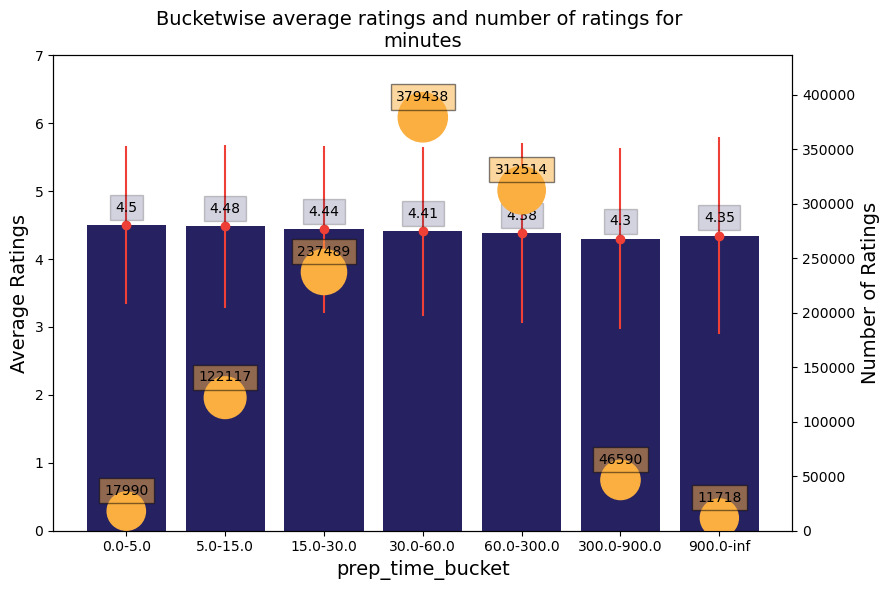

In [76]:
splits = [0, 5, 15, 30, 60, 300, 900, float('Inf')]
inputCol  = "minutes"
outputCol = "prep_time_bucket"

(Interaction_level_df, prep_time_bucketizer, prep_time_summary_pandas_df) = bucket_col_print_summary(df = Interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

#### 3. n_steps

1. Clearly relevant
2. Recipes with less than 2 steps are rated high
3. Recipes with more than 29 steps are rated very low

In [77]:
get_quantiles(df = Interaction_level_df, col_name = "n_steps")

{0.0: 0, 0.01: 2.0, 0.25: 6.0, 0.5: 8.0, 0.75: 12.0, 0.99: 29.0, 1.0: 145}

In [78]:
Interaction_level_df.filter('n_steps == 0').show(5, truncate = False)

+-------+---------+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------------+------+-------+--------------+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [79]:
get_n_items_satisfying_condition(df = Interaction_level_df,
                                 condition = 'n_steps == 0',aggregation_level = "recipe")

Condition String                   : "n_steps == 0"
Num Recipes Satisfying Condition   : 1 [0.0%]
Total Num Recipes                  : 230543


In [80]:
# Remove recipes with n_steps zero
Interaction_level_df = Interaction_level_df.filter("n_steps > 0")

Added bucketized column n_steps_bucket

Bucketing done for split definition: [0, 2, 6, 8, 12, 29, inf]

Printing summary statistics for ratings in buckets below:


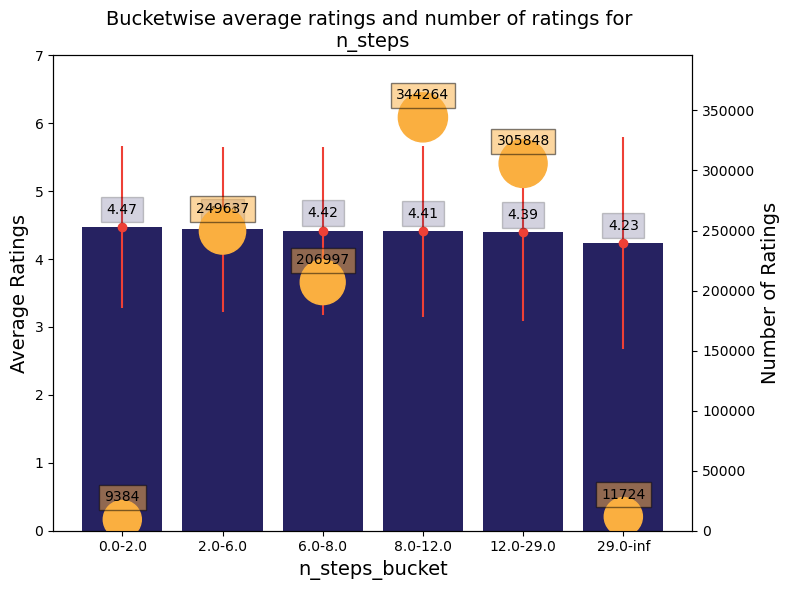

In [81]:
splits = [0, 2, 6, 8, 12, 29, float('Inf')]
inputCol  = "n_steps"
outputCol = "n_steps_bucket"
(Interaction_level_df, n_steps_bucketizer, n_steps_pandas_df) = bucket_col_print_summary(df = Interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

#### 4. n_ingredients

Not relevant

In [82]:
get_quantiles(df = Interaction_level_df, col_name = "n_ingredients")

{0.0: 1, 0.01: 2.0, 0.25: 6.0, 0.5: 9.0, 0.75: 11.0, 0.99: 20.0, 1.0: 43}

Added bucketized column n_ingredients_bucket

Bucketing done for split definition: [0, 6, 9, 11, inf]

Printing summary statistics for ratings in buckets below:


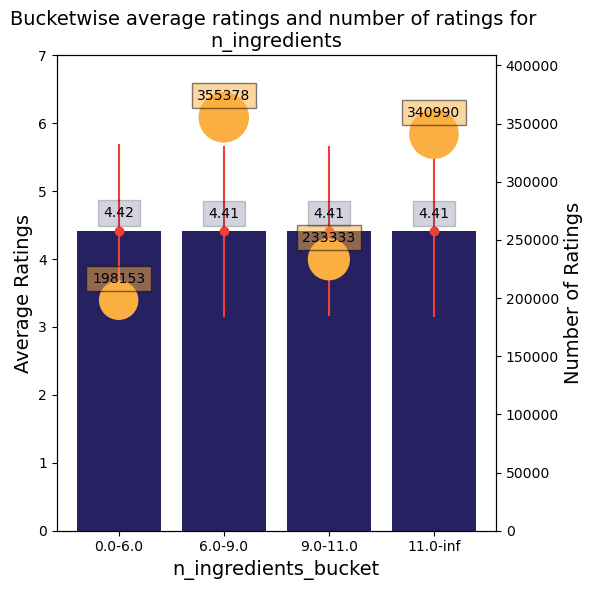

In [83]:
splits = [0, 6, 9, 11, float('Inf')]
inputCol  = "n_ingredients"
outputCol = "n_ingredients_bucket"

(Interaction_level_df, n_ingredients_bucketizer, n_ingredients_pandas_df) = bucket_col_print_summary(df = Interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol, outputCol = outputCol)

#### 5. nutrition columns







1. calories - Calories per serving seems irrelevant
2. fat (per 100 cal) - Calories per serving seems irrelevant
3. sugar (per 100 cal) - Calories per serving seems irrelevant
4. sodium (per 100 cal) - Calories per serving seems irrelevant
5. protein (per 100 cal) - Calories per serving seems irrelevant
6. sat. fat (per 100 cal) - Calories per serving seems irrelevant
7. carbs (per 100 cal) - Calories per serving seems irrelevant

In [84]:
Interaction_level_df.columns 


['user_id',
 'recipe_id',
 'rating',
 'review',
 'review_date',
 'name',
 'id',
 'minutes',
 'contributor_id',
 'submitted',
 'tags',
 'nutrition',
 'n_steps',
 'steps',
 'description',
 'ingredients',
 'n_ingredients',
 'calories',
 'total_fat_PDV',
 'sugar_PDV',
 'sodium_PDV',
 'protein_PDV',
 'saturated_fat_PDV',
 'carbohydrates_PDV',
 'total_fat_per_100_cal',
 'sugar_per_100_cal',
 'sodium_per_100_cal',
 'protein_per_100_cal',
 'saturated_fat_per_100_cal',
 'carbohydrates_per_100_cal',
 'days_since_submission_on_review_date',
 'months_since_submission_on_review_date',
 'years_since_submission_on_review_date',
 'prep_time_bucket',
 'n_steps_bucket',
 'n_ingredients_bucket']

In [85]:
nutrition_cols = ['calories', 
                  'total_fat_PDV', 
                  'sugar_PDV', 
                  'sodium_PDV', 
                  'protein_PDV', 
                  'saturated_fat_PDV', 
                  'carbohydrates_PDV', 
                  'total_fat_per_100_cal', 
                  'sugar_per_100_cal', 
                  'sodium_per_100_cal', 
                  'protein_per_100_cal', 
                  'saturated_fat_per_100_cal', 
                  'carbohydrates_per_100_cal']

quantiles_list = [0.00, 0.05, 0.25, 0.5, 0.75, 0.95, 1.00]
nutrition_col_quantiles = pd.DataFrame(index = quantiles_list)

In [86]:
for col in nutrition_cols:
    nutrition_col_quantiles[col] = (get_quantiles(df = Interaction_level_df,
                                                col_name = col,
                                                quantiles_list=quantiles_list)
                                  .values())

In [88]:
nutrition_col_quantile_summary = pd.DataFrame(index = ["0.00-0.25", "0.25-0.50", "0.50-0.75", "0.75-0.95", "0.95 - 1.00"])

for col in nutrition_cols:
    splits = ([0]
            + list(nutrition_col_quantiles.loc[[0.25, 0.5, 0.75, 0.95], col].round())
            + [float('Inf')])
    inputCol  = col
    outputCol = col+"_bucket"

    if outputCol in interaction_level_df.columns:
        interaction_level_df = interaction_level_df.drop(outputCol)

  # Training bucketizer
    bucketizer = Bucketizer(splits = splits,
                          inputCol  = inputCol,
                          outputCol = outputCol)
  
    interaction_level_df = bucketizer.setHandleInvalid("keep").transform(interaction_level_df)
  
    nutrition_col_quantile_summary.loc[:, col] = (interaction_level_df
                                                .groupBy(outputCol)
                                                .agg(F.avg('rating').alias('avg_rating'))
                                                .sort(outputCol)
                                                .select('avg_rating').toPandas().values)

In [90]:
# set the max columns to none
pd.set_option('display.max_columns', None)

In [91]:
nutrition_col_quantile_summary

,calories,total_fat_PDV,sugar_PDV,sodium_PDV,protein_PDV
0.00-0.25,4.416199,4.393521,4.416395,4.423891,4.422676
0.25-0.50,4.428172,4.420993,4.434607,4.408542,4.419295
0.50-0.75,4.418460,4.427685,4.402974,4.422323,4.410519
0.75-0.95,4.393675,4.411923,4.406989,4.397182,4.399871
0.95 - 1.00,4.341801,4.371065,4.332856,4.373175,4.372622


# Feature Extraction Part 02

## Read The Data

In [93]:
def add_OHE_columns (df, n_name_list):
    """
    Given a list of tags, creates one hot encoded columns for each tag. 
  
    Input
    Argument 1: Dataframe in which the function will add the new columns
    Argument 2: list of tags
  
    Output
    Prints the names of columns that have been added 
    Returns the modified dataframe 
    """
    for name in n_name_list:
        df = (df.withColumn("has_tag_"+name, F.when(F.array_contains(df.tags, name), 1).otherwise(0)))
        print ("added column: has_tag_"+name)

    return df

### Adding user level average features

In [94]:
partition = Window.partitionBy("user_id")

Interaction_level_df = (Interaction_level_df
                        .withColumn("user_avg_rating",
                                    F.avg(F.col("rating")).over(partition))
                        .withColumn("user_n_ratings",
                                    F.count(F.col("rating")).over(partition))
                        .withColumn("user_avg_years_betwn_review_and_submission",
                                    F.avg(F.col("years_since_submission_on_review_date")).over(partition))
                        .withColumn("user_avg_prep_time_recipes_reviewed",
                                    F.avg(F.col("minutes")).over(partition))
                        .withColumn("user_avg_n_steps_recipes_reviewed",
                                    F.avg(F.col("n_steps")).over(partition))
                        .withColumn("user_avg_n_ingredients_recipes_reviewed",
                                    F.avg(F.col("n_ingredients")).over(partition)))

In [95]:
nutrition_cols = ['calories',
                  'total_fat_per_100_cal',
                  'sugar_per_100_cal',
                  'sodium_per_100_cal',
                  'protein_per_100_cal',
                  'saturated_fat_per_100_cal',
                  'carbohydrates_per_100_cal']

for nutri_col in nutrition_cols:
    Interaction_level_df = (Interaction_level_df
                            .withColumn("user_avg_{}_recipes_reviewed".format(nutri_col),
                                        F.avg(F.col(nutri_col)).over(partition)))

In [96]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code. 

assert(round(Interaction_level_df.filter('user_id == 601529').select('user_avg_rating').first()[0], 2) == 4.22)
assert(Interaction_level_df.filter('user_id == 601529').select('user_n_ratings').first()[0] == 27)
assert(round(Interaction_level_df.filter('user_id == 601529').select('user_avg_years_betwn_review_and_submission').first()[0], 2) == 3.51)
assert(Interaction_level_df.filter('user_id == 233044').select('user_avg_prep_time_recipes_reviewed').first()[0] == 50.3)
assert(Interaction_level_df.filter('user_id == 233044').select('user_avg_n_steps_recipes_reviewed').first()[0] == 8.8)
assert(Interaction_level_df.filter('user_id == 233044').select('user_avg_n_ingredients_recipes_reviewed').first()[0] == 8.2)
assert(round(Interaction_level_df.filter('user_id == 233044').select('user_avg_total_fat_per_100_cal_recipes_reviewed').first()[0]) == 6)

#### More Features:

1. high_ratings = 5 rating

2. user_avg_years_betwn_review_and_submission_high_ratings
3. user_avg_prep_time_recipes_reviewed_high_ratings
4. user_avg_n_steps_recipes_reviewed_high_ratings
5. user_avg_n_ingredients_recipes_reviewed_high_ratings

In [97]:
Interaction_level_df = (Interaction_level_df
                        .withColumn("ind_5_rating",
                                    F.when(interaction_level_df["rating"] != 5, None)
                                     .otherwise(1))
                        .withColumn("years_since_submission_on_review_date_5_ratings",
                                    F.when(interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("years_since_submission_on_review_date")))
                        .withColumn("minutes_5_ratings",
                                    F.when(interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("minutes")))
                        .withColumn("n_steps_5_ratings",
                                    F.when(interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("n_steps")))
                        .withColumn("n_ingredients_5_ratings",
                                    F.when(interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("n_ingredients"))))

In [98]:
nutrition_cols = ['calories',
                  'total_fat_per_100_cal',
                  'sugar_per_100_cal',
                  'sodium_per_100_cal',
                  'protein_per_100_cal',
                  'saturated_fat_per_100_cal',
                  'carbohydrates_per_100_cal']

for nutri_col in nutrition_cols:
    Interaction_level_df = (Interaction_level_df
                            .withColumn("user_avg_{}_recipes_reviewed".format(nutri_col),
                                        F.avg(F.col(nutri_col)).over(partition)))

In [99]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code. 

assert(round(Interaction_level_df.filter('user_id == 601529').select('user_avg_rating').first()[0], 2) == 4.22)
assert(Interaction_level_df.filter('user_id == 601529').select('user_n_ratings').first()[0] == 27)
assert(round(Interaction_level_df.filter('user_id == 601529').select('user_avg_years_betwn_review_and_submission').first()[0], 2) == 3.51)
assert(Interaction_level_df.filter('user_id == 233044').select('user_avg_prep_time_recipes_reviewed').first()[0] == 50.3)
assert(Interaction_level_df.filter('user_id == 233044').select('user_avg_n_steps_recipes_reviewed').first()[0] == 8.8)
assert(Interaction_level_df.filter('user_id == 233044').select('user_avg_n_ingredients_recipes_reviewed').first()[0] == 8.2)
assert(round(Interaction_level_df.filter('user_id == 233044').select('user_avg_total_fat_per_100_cal_recipes_reviewed').first()[0]) == 6)

#### More Features:

1. high_ratings = 5 rating

2. user_avg_years_betwn_review_and_submission_high_ratings
3. user_avg_prep_time_recipes_reviewed_high_ratings
4. user_avg_n_steps_recipes_reviewed_high_ratings
5. user_avg_n_ingredients_recipes_reviewed_high_ratings

In [100]:
Interaction_level_df = (Interaction_level_df
                        .withColumn("ind_5_rating",
                                    F.when(Interaction_level_df["rating"] != 5, None)
                                     .otherwise(1))
                        .withColumn("years_since_submission_on_review_date_5_ratings",
                                    F.when(Interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("years_since_submission_on_review_date")))
                        .withColumn("minutes_5_ratings",
                                    F.when(Interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("minutes")))
                        .withColumn("n_steps_5_ratings",
                                    F.when(Interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("n_steps")))
                        .withColumn("n_ingredients_5_ratings",
                                    F.when(Interaction_level_df["rating"] != 5, None)
                                     .otherwise(F.col("n_ingredients"))))

In [101]:
partition = Window.partitionBy("user_id")

Interaction_level_df = (Interaction_level_df
                        .withColumn("user_n_5_ratings",
                                    F.sum(F.col("ind_5_rating")).over(partition))
                        .withColumn("user_avg_years_betwn_review_and_submission_5_ratings",
                                    F.avg(F.col("years_since_submission_on_review_date_5_ratings")).over(partition))
                        .withColumn("user_avg_prep_time_recipes_reviewed_5_ratings",
                                    F.avg(F.col("minutes_5_ratings")).over(partition))
                        .withColumn("user_avg_n_steps_recipes_reviewed_5_ratings",
                                    F.avg(F.col("n_steps_5_ratings")).over(partition))
                        .withColumn("user_avg_n_ingredients_recipes_reviewed_5_ratings",
                                    F.avg(F.col("n_ingredients_5_ratings")).over(partition)))

In [102]:
for nutri_col in nutrition_cols:
    Interaction_level_df = (Interaction_level_df
                            .withColumn("{}_5_ratings".format(nutri_col),
                                        F.when(Interaction_level_df["rating"] != 5, None)
                                         .otherwise(F.col(nutri_col))))
    Interaction_level_df = (Interaction_level_df
                            .withColumn("user_avg_{}_recipes_reviewed_5_ratings".format(nutri_col),
                                        F.avg(F.col("{}_5_ratings".format(nutri_col))).over(partition)))

In [103]:
# Check - All rows with ratings should have non-null values in corresponding user_avg_5_ratings columns

assert(Interaction_level_df
       .filter("rating == 5")
       .filter(Interaction_level_df.user_n_5_ratings.isNull() |
               Interaction_level_df.user_avg_years_betwn_review_and_submission_5_ratings.isNull() |
               Interaction_level_df.user_avg_prep_time_recipes_reviewed_5_ratings.isNull() |
               Interaction_level_df.user_avg_n_steps_recipes_reviewed_5_ratings.isNull() |
               Interaction_level_df.user_avg_n_ingredients_recipes_reviewed_5_ratings.isNull())
       .count() == 0)

In [104]:
# Check values for a given user id

assert(Interaction_level_df.filter('user_id == 233044').select('user_n_5_ratings').first()[0] == 7)
assert(round(Interaction_level_df.filter('user_id == 233044').select('user_avg_years_betwn_review_and_submission_5_ratings').first()[0], 2) == 2.24)
assert(round(Interaction_level_df.filter('user_id == 233044').select('user_avg_prep_time_recipes_reviewed_5_ratings').first()[0]) == 46)
assert(round(Interaction_level_df.filter('user_id == 233044').select('user_avg_n_steps_recipes_reviewed_5_ratings').first()[0], 2) == 7.29)
assert(round(Interaction_level_df.filter('user_id == 233044').select('user_avg_n_ingredients_recipes_reviewed_5_ratings').first()[0], 2) == 6.86)

In [105]:
interaction_level_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- recipe_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- minutes: integer (nullable = true)
 |-- contributor_id: integer (nullable = true)
 |-- submitted: date (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- nutrition: string (nullable = true)
 |-- n_steps: integer (nullable = true)
 |-- steps: string (nullable = true)
 |-- description: string (nullable = true)
 |-- ingredients: string (nullable = true)
 |-- n_ingredients: integer (nullable = true)
 |-- calories: float (nullable = true)
 |-- total_fat_PDV: float (nullable = true)
 |-- sugar_PDV: float (nullable = true)
 |-- sodium_PDV: float (nullable = true)
 |-- protein_PDV: float (nullable = true)
 |-- saturated_fat_PDV: float (nullable = true)
 |-- carbo

## Tags level EDA

In [106]:
Interaction_tag_level_df = interaction_level_df.withColumn('individual_tag',F.explode('tags'))

In [107]:
tags_ratings_summary = (Interaction_tag_level_df
                        .groupBy('individual_tag').agg(F.avg('rating').alias('avg_user_rating'),
                                                    #  F.max('rating').alias('max_user_rating'),
                                                    #  F.min('rating').alias('min_user_rating'),
                                                       F.count('rating').alias('n_user_ratings'),
                                                       F.countDistinct('id').alias('n_recipes')))

In [108]:
Interactions, recipes  =  Interaction_level_df.count(), Interaction_level_df.agg(F.countDistinct('id')).first()[0]

tags_ratings_summary = (tags_ratings_summary.withColumn("in_percent_recipies", F.col ("n_recipes")/F.lit(recipes))
                                            .withColumn("in_percent_interactions", F.col ("n_user_ratings")/F.lit(Interactions)))

### 1. Top n most rated tags

In [109]:
tags_ratings_summary.sort(F.col("n_user_ratings").desc()).show(20)

+------------------+------------------+--------------+---------+-------------------+-----------------------+
|    individual_tag|   avg_user_rating|n_user_ratings|n_recipes|in_percent_recipies|in_percent_interactions|
+------------------+------------------+--------------+---------+-------------------+-----------------------+
|       preparation| 4.411354948648275|       1129076|   230546| 1.0000173504177112|     1.0010834735701606|
|      time-to-make|4.4138409064517266|       1110881|   225326| 0.9773750553044565|     0.9849510663614263|
|            course| 4.411947223592061|       1076769|   218148| 0.9462397307215171|     0.9547060169135366|
|           dietary| 4.411331005472605|        906698|   165091| 0.7160994525943212|     0.8039143364300698|
|   main-ingredient| 4.423460446350231|        868466|   170446| 0.7393273243053327|     0.7700163319011148|
|              easy|  4.41807043683746|        632226|   126062| 0.5468070893806768|     0.5605565968644878|
|          occasion

In [110]:
tags_ratings_summary = tags_ratings_summary.filter(tags_ratings_summary.in_percent_interactions < 0.75)

In [111]:
top_most_frequent_tags = tags_ratings_summary.sort(F.col("n_user_ratings").desc())

In [112]:
get_quantiles(df = top_most_frequent_tags , 
              col_name = 'in_percent_interactions', 
              quantiles_list = [0.01,0.25,0.5, 0.75,0.8,0.85,0.9,0.95, 0.99])

{0.0: 8.86639582782878e-07,
 0.01: 8.86639582782878e-07,
 0.25: 0.00035908903102706556,
 0.5: 0.003421542149959126,
 0.75: 0.019063637669414657,
 0.8: 0.02747784731002417,
 0.85: 0.04430183339332928,
 0.9: 0.08095640038515624,
 0.95: 0.16427924181675996,
 0.99: 0.34169582233161383,
 1.0: 0.5605565968644878}

In [113]:
# keep tags appearing in the top 5 percentile 
top_most_frequent_tags = top_most_frequent_tags.filter("in_percent_interactions > 0.16")

top_most_frequent_tags.count()

29

In [114]:
top_frequent_tags_list = [data[0] for data in top_most_frequent_tags.select('individual_tag').collect()]

In [115]:
Interaction_level_df = add_OHE_columns (Interaction_level_df, top_frequent_tags_list)

added column: has_tag_easy
added column: has_tag_occasion
added column: has_tag_equipment
added column: has_tag_cuisine
added column: has_tag_low-in-something
added column: has_tag_main-dish
added column: has_tag_60-minutes-or-less
added column: has_tag_number-of-servings
added column: has_tag_meat
added column: has_tag_taste-mood
added column: has_tag_north-american
added column: has_tag_30-minutes-or-less
added column: has_tag_vegetables
added column: has_tag_oven
added column: has_tag_4-hours-or-less
added column: has_tag_low-carb
added column: has_tag_holiday-event
added column: has_tag_desserts
added column: has_tag_healthy
added column: has_tag_15-minutes-or-less
added column: has_tag_dinner-party
added column: has_tag_low-sodium
added column: has_tag_american
added column: has_tag_beginner-cook
added column: has_tag_low-cholesterol
added column: has_tag_low-calorie
added column: has_tag_inexpensive
added column: has_tag_comfort-food
added column: has_tag_kid-friendly


### 2. Bottom n least rated tags

In [116]:
tags_ratings_summary.sort(F.col("n_user_ratings").asc()).show(5)

+--------------------+---------------+--------------+---------+-------------------+-----------------------+
|      individual_tag|avg_user_rating|n_user_ratings|n_recipes|in_percent_recipies|in_percent_interactions|
+--------------------+---------------+--------------+---------+-------------------+-----------------------+
|             cabbage|            5.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|   chicken-crock-pot|            4.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|       chicken-stews|            4.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|        chicken-stew|            4.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|irish-st-patricks...|            5.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
+--------------------+---------------+--------------+---------+-------------------+-----------------------+
only showing top 5 rows



 The above tags are present in 1 recipe in over two hundred thousand. The features we create based on these tags will not teach the model new information. If these tags were one hot encoded, the entire column would be filled with zeros, and only a few rows will have 1s. One hot encoding of these tags is not a good idea. If you come up with an encoding that captures the rarity of these tags, only then can you add these tags to the analysis.

### 3. Top n rated tags

In [117]:
tags_ratings_summary.sort(F.col('avg_user_rating').desc()).show(5)

+--------------------+---------------+--------------+---------+-------------------+-----------------------+
|      individual_tag|avg_user_rating|n_user_ratings|n_recipes|in_percent_recipies|in_percent_interactions|
+--------------------+---------------+--------------+---------+-------------------+-----------------------+
|     cranberry-sauce|            5.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|roast-beef-comfor...|            5.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|           pork-loin|            5.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|roast-beef-main-dish|            5.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
|             cabbage|            5.0|             1|        1| 4.3376044278266E-6|    8.86639582782878E-7|
+--------------------+---------------+--------------+---------+-------------------+-----------------------+
only showing top 5 rows



In [118]:
get_quantiles(tags_ratings_summary, 'n_user_ratings',quantiles_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.99])

{0.0: 1,
 0.01: 1.0,
 0.05: 1.0,
 0.1: 12.0,
 0.15: 99.0,
 0.2: 187.0,
 0.25: 405.0,
 0.5: 3859.0,
 0.75: 21501.0,
 0.99: 385383.0,
 1.0: 632226}

In [119]:
tags_ratings_summary = tags_ratings_summary.filter(tags_ratings_summary.n_user_ratings > 100)

In [120]:
top_rated_tags_df = tags_ratings_summary.sort(F.col('avg_user_rating').desc())

In [121]:
get_quantiles(df = top_rated_tags_df , 
              col_name = 'avg_user_rating', 
              quantiles_list = [0.01,0.25,0.5, 0.75,0.8,0.85,0.9,0.95, 0.99])

{0.0: 3.6742424242424243,
 0.01: 3.9685714285714284,
 0.25: 4.345410125792702,
 0.5: 4.402761169692358,
 0.75: 4.450265839610102,
 0.8: 4.460339943342777,
 0.85: 4.483529739259534,
 0.9: 4.504750593824228,
 0.95: 4.536693785121194,
 0.99: 4.609756097560975,
 1.0: 4.822727272727272}

In [122]:
# keep tags above 95 percentile
top_rated_tags_df = top_rated_tags_df.filter("avg_user_rating > 4.53")
top_rated_tags_df.count()

26

In [123]:
top_rated_tags_list = [data[0] for data in top_rated_tags_df.select('individual_tag').collect()]

In [124]:
set(top_frequent_tags_list) & set(top_rated_tags_list)

set()

In [125]:
all_added_columns_set = set(top_frequent_tags_list).union(set(top_rated_tags_list))

In [126]:
Interaction_level_df = add_OHE_columns (Interaction_level_df, top_rated_tags_list)

added column: has_tag_ragu-recipe-contest
added column: has_tag_simply-potatoes2
added column: has_tag_non-alcoholic
added column: has_tag_a1-sauce
added column: has_tag_labor-day
added column: has_tag_punch
added column: has_tag_lettuces
added column: has_tag_cocktails
added column: has_tag_mashed-potatoes
added column: has_tag_smoothies
added column: has_tag_avocado
added column: has_tag_turkey-burgers
added column: has_tag_beverages
added column: has_tag_asparagus
added column: has_tag_mango
added column: has_tag_shakes
added column: has_tag_memorial-day
added column: has_tag_omelets-and-frittatas
added column: has_tag_salsas
added column: has_tag_strawberries
added column: has_tag_greek
added column: has_tag_salads
added column: has_tag_barbecue
added column: has_tag_australian
added column: has_tag_grilling
added column: has_tag_polynesian


### 4. Bottom n rated tags

In [127]:
bottom_rated_tags_df = tags_ratings_summary.sort(F.col("avg_user_rating").asc())

In [128]:
get_quantiles (bottom_rated_tags_df, "avg_user_rating", quantiles_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 0.99])

{0.0: 3.6742424242424243,
 0.01: 3.9685714285714284,
 0.02: 4.050793650793651,
 0.03: 4.096069868995633,
 0.04: 4.116788321167883,
 0.05: 4.171974522292993,
 0.1: 4.238095238095238,
 0.15: 4.303225806451613,
 0.2: 4.326197355748183,
 0.25: 4.345410125792702,
 0.5: 4.402761169692358,
 0.75: 4.450265839610102,
 0.99: 4.609756097560975,
 1.0: 4.822727272727272}

In [129]:
bottom_rated_tags_df = bottom_rated_tags_df.filter("avg_user_rating < 4.00")
bottom_rated_tags_df.count()

6

In [130]:
bottom_rated_tags_list = [data[0] for data in bottom_rated_tags_df.select('individual_tag').collect()]

In [131]:
all_added_columns_set & set(bottom_rated_tags_list)

set()

In [132]:
Interaction_level_df =  add_OHE_columns(Interaction_level_df, bottom_rated_tags_list)

added column: has_tag_pressure-canning
added column: has_tag_honduran
added column: has_tag_unprocessed-freezer
added column: has_tag_birthday
added column: has_tag_jellies
added column: has_tag_water-bath


# Final DataFrame

In [133]:
len(Interaction_level_df.columns)

140